## ASSIGNMENT 2
---

**1. Try different imputation methods on the Titanic Dataset, and evaluate classifier accuracies for each of these. A package you can use is fancyimpute.**

## Importing Packages

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)

Lets write some data into the dataframe...

In [2]:
df = pd.read_csv('Titanic_full.csv',index_col=0)
print(df.shape)
df.head(5)

(1309, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Alright, looks like I've got 1309 rows across 11 columns considering that I have specified the first column of the dataframe to be treated as an index **(index_col = 0)**. Moving forward, let's take a holistic look at the data. 

In [3]:
nulls = df.isnull().sum()/len(df)*100
nulls_pct = str(round(nulls,2))
print(nulls_pct)

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         20.09
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.08
Cabin       77.46
Embarked     0.15
dtype: float64


There are a lot of nulls in the dataset that needs to be taken care of. In general practice, anything drastically over 25% is ideally discarded as it will affect the model prediction significantly. So, I drop column 'Cabin' which has almost 78% null values. 

In [4]:
df = df.drop('Cabin', axis=1)
print(df.shape)
df.head(5)

(1309, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Data pre-preprocessing

I am going to preprocess this dataset as following:

1. Convert the entire dataframe to an array of numbers. This will be achieved in two ways: (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Convert catagorical variables into numeric values.

3. Impute or "fill in" missing values or NaNs. We will play with different methods and provide a comparison by plotting a ROC curve after having applied our classifier (In our case, KNN)

4. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


**STEP (1): Converting string types into categories**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Survived    1309 non-null int64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Embarked    1307 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


In [6]:
df.select_dtypes(['object']).columns

Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')

Note that 4 columns are of the datatype Object which needs to be converted into categories. I am writing a lambda function that selects columns having dtype as 'Object' and converts it into category and that should serve our purpose.

In [7]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))    

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Survived    1309 non-null int64
Pclass      1309 non-null int64
Name        1309 non-null category
Sex         1309 non-null category
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null category
Fare        1308 non-null float64
Embarked    1307 non-null category
dtypes: category(4), float64(2), int64(4)
memory usage: 176.9 KB


**STEP (2): Converting categorical variables into integer values**

In [9]:
print(df.Sex.cat.categories)
print(df.Embarked.cat.categories)


Index(['female', 'male'], dtype='object')
Index(['C', 'Q', 'S'], dtype='object')


Check the mappings of the 'Sex' & 'Embarked' categories. I am writing couple of functions that looks for the categorical values and returns an integer. Both these categories are written back to the original dataframe.

In [10]:
def gender_converter(gender):
    if gender=='male':
        return 1
    else:
        return 0
    
def embarked_converter(embarked):
    if embarked=='C':
        return 1
    elif embarked=='Q':
        return 2
    elif embarked=='S':
        return 3

In [11]:
df['Sex'] = df['Sex'].apply(gender_converter)
df['Embarked'] = df['Embarked'].apply(embarked_converter)

df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,3
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,3


**STEP (3): Imputing missing values**

Previously, I eliminated a column with close to 78% nulls. Here, the percentage of missing values might be less but we cannot let them be. Instead, I will go ahead and impute those missing values with the help of some imputers.

I will be implementing 3 imputers:

- **FancyImpute's KNN()** which weights samples using the mean squared difference on features for which two rows both have observed data.
- **FancyImpute's SoftImpute()** which completes the input matrix (array of values) by iterative soft thresholding of SVD decompositions.
- **Scikit-Learn's Iterative Imputer()**  that estimates each feature from all the others. It is a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.
- **Scikit-Learn's Imputer(mean)** that replaces missing data by calculating 'mean' value of each column.
- **Scikit-Learn's SimpleImputer(most_frequent)** that replaces missing data using the most frequent value along each column.

Before we get down to applying our imputer, lets get rid of predictors that do not contribute much to our model as seen in assignment 1. 

In [12]:
df = df.drop(['Name','Ticket'], axis=1)
print(df.shape)
df.head(5)

(1309, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,3
4,1,1,0,35.0,1,0,53.1000,3
5,0,3,1,35.0,0,0,8.0500,3


For the sake of keeping our input data similar and reducing the pain of referring to the original 'imbalanced' dataframe. Lets create copies of our data. We will be applying the imputers and scaling them ready for our classifiers to implement. Each of these copies will contain same number of nulls. 

In [13]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()
df5 = df.copy()

In [14]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

### FancyImpute's KNN()

In [15]:
from fancyimpute import KNN #pip install fancyimpute

df1[['Age','Fare','Embarked']] = KNN(5).fit_transform(df1.iloc[:,[3,6,7]])

Using TensorFlow backend.


Imputing row 1/1309 with 0 missing, elapsed time: 0.332
Imputing row 101/1309 with 0 missing, elapsed time: 0.333
Imputing row 201/1309 with 0 missing, elapsed time: 0.334
Imputing row 301/1309 with 1 missing, elapsed time: 0.335
Imputing row 401/1309 with 0 missing, elapsed time: 0.336
Imputing row 501/1309 with 0 missing, elapsed time: 0.337
Imputing row 601/1309 with 0 missing, elapsed time: 0.338
Imputing row 701/1309 with 0 missing, elapsed time: 0.340
Imputing row 801/1309 with 0 missing, elapsed time: 0.341
Imputing row 901/1309 with 0 missing, elapsed time: 0.341
Imputing row 1001/1309 with 0 missing, elapsed time: 0.342
Imputing row 1101/1309 with 0 missing, elapsed time: 0.344
Imputing row 1201/1309 with 0 missing, elapsed time: 0.345
Imputing row 1301/1309 with 0 missing, elapsed time: 0.346


In [16]:
df1.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

**Step (3): Scaling**

The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. Given the distribution of the data, each value in the dataset will have the sample mean value subtracted, and then divided by the standard deviation of the whole dataset.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df1[['Age','Fare']])
df1[['Age','Fare']] = scaler.transform(df1[['Age','Fare']])

### Train-valid-test split

We plit the data into three sets in a 70-15-15 manner. This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into evaluating model performance as you manually change or set the model hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). This dataset is sometimes called a holdout set or the validation set. Finally, the last 15% of the data is the test set.  This dataset is never "seen" by the model for model building or hyperparamter tuning. After hyperparameter tuning and model selection, which we will discuss later, the model's final performance before sneidng it to production, will be evalauted on this test data set.

I achieved this with a two-step process
1. Split the source dataset into 70%(training)/30%(validation + test)
2. Split the 30%(validation + test) into 2 halves: 15%(validation)/15%(test)

In [18]:
from sklearn.model_selection import train_test_split

y = df1['Survived']
X = df1.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_train1, X_val_test1, y_train1, y_val_test1 = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_val_test1, y_val_test1, test_size=0.50)

print("Training Set:", X_train1.shape)
print("Validation Set:", X_val1.shape)
print("Test Set:", X_test1.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


Next, lets implement our classifier. Here I am going to select the best parameters for our model that were rendered by GridSearchCV in assignment 1. 

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

knn1 = KNeighborsClassifier(n_neighbors=27,weights = 'uniform', metric = 'manhattan')

knn1.fit(X_train1,y_train1)
pred_val1 = knn1.predict(X_val1)

report = classification_report(y_val1,pred_val1)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.75      0.75      0.75       122
           1       0.59      0.58      0.59        74

    accuracy                           0.69       196
   macro avg       0.67      0.67      0.67       196
weighted avg       0.69      0.69      0.69       196



We know the overall accuracy of our classifier so lets try and calculate the ROC score. 

The point of a ROC curve (and the area under it) is that you study the precision-recall tradeoff as the classification threshold is varied. By default in a binary classification task, if your classifier's score is > 0.5, then class1 is predicted, otherwise class0 is predicted. As you change that threshold, you get a curve. The higher up the curve is (more area under it), the better that classifier. However, to get this curve you need access to the scores of a classifier, not its decisions. Otherwise whatever the decision threshold is, the decision stay the same, and AUC degenerates to accuracy.

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn import metrics

knn1_accuracy = np.round(accuracy_score(y_val1,pred_val1),2)
print("Accuracy score:",knn1_accuracy) 

# calculate the fpr and tpr for all thresholds of the classification
probs = knn1.predict_proba(X_val1)
preds = probs[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_val1,pred_val1)
roc_auc1 = metrics.auc(fpr1, tpr1)

print('ROC AUC:',np.round(roc_auc1,2))

Accuracy score: 0.69
ROC AUC: 0.67


### FancyImpute's SoftImpute()

In [21]:
from fancyimpute import SoftImpute

df2[['Age','Fare','Embarked']] = SoftImpute().fit_transform(df2.iloc[:,[3,6,7]])

[SoftImpute] Max Singular Value of X_init = 2313.581507
[SoftImpute] Iter 1: observed MAE=0.953981 rank=3
[SoftImpute] Iter 2: observed MAE=0.955095 rank=3
[SoftImpute] Iter 3: observed MAE=0.955242 rank=3
[SoftImpute] Iter 4: observed MAE=0.955331 rank=3
[SoftImpute] Iter 5: observed MAE=0.955410 rank=3
[SoftImpute] Iter 6: observed MAE=0.955502 rank=3
[SoftImpute] Iter 7: observed MAE=0.955579 rank=3
[SoftImpute] Iter 8: observed MAE=0.955647 rank=3
[SoftImpute] Iter 9: observed MAE=0.955698 rank=3
[SoftImpute] Iter 10: observed MAE=0.955734 rank=3
[SoftImpute] Iter 11: observed MAE=0.955759 rank=3
[SoftImpute] Iter 12: observed MAE=0.955791 rank=3
[SoftImpute] Iter 13: observed MAE=0.955817 rank=3
[SoftImpute] Iter 14: observed MAE=0.955833 rank=3
[SoftImpute] Iter 15: observed MAE=0.955840 rank=3
[SoftImpute] Iter 16: observed MAE=0.955839 rank=3
[SoftImpute] Iter 17: observed MAE=0.955831 rank=3
[SoftImpute] Iter 18: observed MAE=0.955818 rank=3
[SoftImpute] Iter 19: observed MAE=

In [22]:
scaler = StandardScaler()
scaler.fit(df2[['Age','Fare']])
df2[['Age','Fare']] = scaler.transform(df2[['Age','Fare']])

In [23]:
y = df2['Survived']
X = df2.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_train2, X_val_test2, y_train2, y_val_test2 = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val_test2, y_val_test2, test_size=0.50)

print("Training Set:", X_train2.shape)
print("Validation Set:", X_val2.shape)
print("Test Set:", X_test2.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


In [24]:
knn2 = KNeighborsClassifier(n_neighbors=27,weights = 'uniform', metric = 'manhattan')

knn2.fit(X_train2,y_train2)
pred_val2 = knn2.predict(X_val2)

report = classification_report(y_val2,pred_val2)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.73      0.84      0.79       128
           1       0.59      0.43      0.50        68

    accuracy                           0.70       196
   macro avg       0.66      0.64      0.64       196
weighted avg       0.69      0.70      0.68       196



In [25]:
knn2_accuracy = np.round(accuracy_score(y_val2,pred_val2),2)
print("Accuracy score:",knn2_accuracy) 

# calculate the fpr and tpr for all thresholds of the classification
probs = knn2.predict_proba(X_val2)
preds = probs[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_val2,pred_val2)
roc_auc2 = metrics.auc(fpr2, tpr2)

print('ROC AUC:',np.round(roc_auc2,2))

Accuracy score: 0.7
ROC AUC: 0.64


### Scikit Learn's IterativeImputer()

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imp = IterativeImputer(max_iter=10, random_state=0)

df3[['Age','Fare','Embarked']] = iter_imp.fit_transform(df3.iloc[:,[3,6,7]])

In [27]:
df3.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [28]:
scaler = StandardScaler()
scaler.fit(df3[['Age','Fare']])
df3[['Age','Fare']] = scaler.transform(df3[['Age','Fare']])

In [29]:
y = df3['Survived']
X = df3.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_train3, X_val_test3, y_train3, y_val_test3 = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val3, X_test3, y_val3, y_test3 = train_test_split(X_val_test3, y_val_test3, test_size=0.50)

print("Training Set:", X_train3.shape)
print("Validation Set:", X_val3.shape)
print("Test Set:", X_test3.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


In [30]:
knn3 = KNeighborsClassifier(n_neighbors=27,weights = 'uniform', metric = 'manhattan')

knn3.fit(X_train3,y_train3)
pred_val3 = knn3.predict(X_val3)

report = classification_report(y_val3,pred_val3)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.69      0.86      0.76       113
           1       0.71      0.47      0.57        83

    accuracy                           0.69       196
   macro avg       0.70      0.66      0.66       196
weighted avg       0.70      0.69      0.68       196



In [31]:
knn3_accuracy = np.round(accuracy_score(y_val3,pred_val3),2)
print("Accuracy score:",knn3_accuracy) 

# calculate the fpr and tpr for all thresholds of the classification
probs = knn3.predict_proba(X_val3)
preds = probs[:,1]
fpr3, tpr3, threshold3 = metrics.roc_curve(y_val3,pred_val3)
roc_auc3 = metrics.auc(fpr3, tpr3)

print('ROC AUC:',np.round(roc_auc3,2))

Accuracy score: 0.69
ROC AUC: 0.66


### Scikit-Learn's Imputer()

In [32]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df4.iloc[:,[3,6,7]])

df4[['Age','Fare','Embarked']] = imp.fit_transform(df4.iloc[:,[3,6,7]])

C:\Users\gaure\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
df4.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df4[['Age','Fare']])
df4[['Age','Fare']] = scaler.transform(df4[['Age','Fare']])

In [35]:
y = df4['Survived']
X = df4.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_train4, X_val_test4, y_train4, y_val_test4 = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val4, X_test4, y_val4, y_test4 = train_test_split(X_val_test4, y_val_test4, test_size=0.50)

print("Training Set:", X_train4.shape)
print("Validation Set:", X_val4.shape)
print("Test Set:", X_test4.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

knn4 = KNeighborsClassifier(n_neighbors=27,weights = 'uniform', metric = 'manhattan')

knn4.fit(X_train4,y_train4)
pred_val4 = knn4.predict(X_val4)

report = classification_report(y_val4,pred_val4)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.75      0.79      0.77       126
           1       0.58      0.51      0.55        70

    accuracy                           0.69       196
   macro avg       0.66      0.65      0.66       196
weighted avg       0.69      0.69      0.69       196



In [37]:
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn import metrics

knn4_accuracy = np.round(accuracy_score(y_val4,pred_val4),2)
print("Accuracy score:",knn4_accuracy) 

# calculate the fpr and tpr for all thresholds of the classification
probs = knn4.predict_proba(X_val4)
preds = probs[:,1]
fpr4, tpr4, threshold4 = metrics.roc_curve(y_val4,pred_val4)
roc_auc4 = metrics.auc(fpr4, tpr4)

print('ROC AUC:',np.round(roc_auc4,2))

Accuracy score: 0.69
ROC AUC: 0.65


### Scitkit Learn's SimpleImputer()

In [38]:
from sklearn.impute import SimpleImputer

si = SimpleImputer( strategy='most_frequent')
si.fit(df5.iloc[:,[3,6,7]])

df5[['Age','Fare','Embarked']] = imp.fit_transform(df5.iloc[:,[3,6,7]])

In [39]:
df5.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [40]:
scaler = StandardScaler()
scaler.fit(df5[['Age','Fare']])
df5[['Age','Fare']] = scaler.transform(df5[['Age','Fare']])

In [41]:
y = df5['Survived']
X = df5.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_train5, X_val_test5, y_train5, y_val_test5 = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val5, X_test5, y_val5, y_test5 = train_test_split(X_val_test5, y_val_test5, test_size=0.50)

print("Training Set:", X_train5.shape)
print("Validation Set:", X_val5.shape)
print("Test Set:", X_test5.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


In [42]:
knn5 = KNeighborsClassifier(n_neighbors=27,weights = 'uniform', metric = 'manhattan')

knn5.fit(X_train5,y_train5)
pred_val5 = knn5.predict(X_val5)

report = classification_report(y_val5,pred_val5)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.80      0.83      0.82       126
           1       0.68      0.63      0.65        70

    accuracy                           0.76       196
   macro avg       0.74      0.73      0.73       196
weighted avg       0.76      0.76      0.76       196



In [43]:
knn5_accuracy = np.round(accuracy_score(y_val5,pred_val5),2)
print("Accuracy score:",knn5_accuracy) 

# calculate the fpr and tpr for all thresholds of the classification
probs = knn5.predict_proba(X_val5)
preds = probs[:,1]
fpr5, tpr5, threshold5 = metrics.roc_curve(y_val5,pred_val5)
roc_auc5 = metrics.auc(fpr5, tpr5)

print('ROC AUC:',np.round(roc_auc5,2))

Accuracy score: 0.76
ROC AUC: 0.73


### Plotting ROC curve

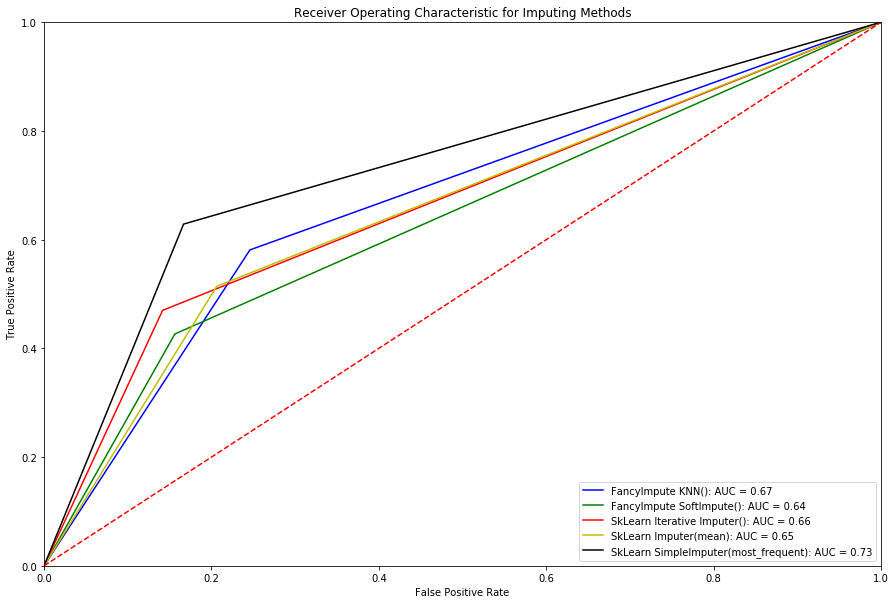

In [44]:
plt.figure(figsize=(15,10))
plt.title('Receiver Operating Characteristic for Imputing Methods')
plt.plot(fpr1, tpr1, 'b', label = 'FancyImpute KNN(): AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'FancyImpute SoftImpute(): AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'r', label = 'SkLearn Iterative Imputer(): AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'y', label = 'SkLearn Imputer(mean): AUC = %0.2f' % roc_auc4)
plt.plot(fpr5, tpr5, 'black', label = 'SkLearn SimpleImputer(most_frequent): AUC = %0.2f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Looks like Sklearn's SimpleImputer(most_frequent) has the best performance amongst all. Now lets find out the test set accuracy on the soft imputed data i.e df1. Training set accuracy was 76%

In [65]:
knn5.fit(X_train5,y_train5)
pred_test5 = knn5.predict(X_test5)

report = classification_report(y_test5,pred_test5)
print("Test set classification report:\n\n", report)

Test set classification report:

               precision    recall  f1-score   support

           0       0.73      0.82      0.77       119
           1       0.66      0.54      0.59        78

    accuracy                           0.71       197
   macro avg       0.69      0.68      0.68       197
weighted avg       0.70      0.71      0.70       197



Accuracy actually decreased from 76% to 71%

---

**2. Briefly describe how gradient boosting differs from bagging. Implement gradient boosting as invoked in scikit-learn, and evaluate classifier accuracy for the Titanic dataset**

- Bagging and Boosting both are ensemble methods that get N learners by generating additional data by random sampling with replacement from the original set. By sampling with replacement, some observations may be repeated in each new training data set. In the case of Bagging, any element has the same probability to appear in a new data set. However, for Boosting the observations are weighted and therefore some of them will take part in the new sets more often
- Both methods make the final decision by averaging the N learners but for Bagging it is a equally weighted average whereas for Boosting more weight is accounted to those with better performance on training data.
- Both are equally good at reducing variance but only boosting tries to reduce bias

So, for this particular task, I will be using df5 copy of our data since it has already been scaled and imputed with Sklearn's Imputer() which evidently gives us the best performances for a classifier. 

In [66]:
df5.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,-0.611972,1,0,-0.503595,3.0
2,1,1,0,0.630431,1,0,0.734503,1.0
3,1,3,0,-0.301371,0,0,-0.490544,3.0
4,1,1,0,0.397481,1,0,0.382925,3.0
5,0,3,1,0.397481,0,0,-0.488127,3.0


### Train-valid-test split for gradient boosting

In [67]:
y = df5['Survived']
X = df5.drop('Survived', axis=1)

# 70% training and 30% validation + test
X_traingb, X_val_testgb, y_traingb, y_val_testgb = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_valgb, X_testgb, y_valgb, y_testgb = train_test_split(X_val_testgb, y_val_testgb, test_size=0.50)

print("Training Set:", X_traingb.shape)
print("Validation Set:", X_valgb.shape)
print("Test Set:", X_testgb.shape)

Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


Fitting Gradient Boosting Classifier on train set to predict validation set...

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_traingb, y_traingb)
pred_valgb = gb.predict(X_valgb)

report = classification_report(y_valgb,pred_valgb)
print("Validation set classification report:\n\n", report)

Validation set classification report:

               precision    recall  f1-score   support

           0       0.71      0.90      0.80       122
           1       0.71      0.41      0.52        74

    accuracy                           0.71       196
   macro avg       0.71      0.65      0.66       196
weighted avg       0.71      0.71      0.69       196



In [69]:
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score

print("Accuracy score:",np.round(accuracy_score(y_valgb,pred_valgb),2)) 
print("MCC:",np.round(matthews_corrcoef(y_valgb,pred_valgb),2))
print("f1 score:",np.round(f1_score(y_valgb,pred_valgb),2))

Accuracy score: 0.71
MCC: 0.36
f1 score: 0.52


Accuracy comes out to be 71% which is not good for now. But again we haven't really hypertuned the model. 

**3. Theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability. How would you design and evaluate a computational experiment to test this on the Titanic dataset.** 

---

Lets hypertune the model here!

The default estimators and learning rate for Scikit learn's GradientBoostingClassifier() is 100 and 0.1 respectively. The default values have resulted in an accuracy of 71% which is definitely not good. So lets try and see if that can be improved. 

I am going to pass an array of different estimator values and learning rates. Maximum features considered will be 3 as suggested by Scikit learn as 30-40% of total features (10).

In [70]:
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for estimator in estimators:
    learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
    for learning_rate in learning_rates:
        gb = GradientBoostingClassifier(n_estimators = estimator, learning_rate = learning_rate, max_features=3, max_depth = 3, random_state = 0)
        gb.fit(X_traingb, y_traingb)
        print("Number of estimators: ", estimator)
        print("Learning rate: ", learning_rate)
        print("Accuracy score (training): {0:.3f}".format(gb.score(X_traingb, y_traingb)))
        pred_testgb = gb.predict(X_testgb)
        print("Accuracy score (test):",np.round(accuracy_score(y_testgb,pred_testgb),3)) 
        print()

Number of estimators:  10
Learning rate:  0.05
Accuracy score (training): 0.676
Accuracy score (test): 0.64

Number of estimators:  10
Learning rate:  0.1
Accuracy score (training): 0.728
Accuracy score (test): 0.701

Number of estimators:  10
Learning rate:  0.25
Accuracy score (training): 0.750
Accuracy score (test): 0.726

Number of estimators:  10
Learning rate:  0.5
Accuracy score (training): 0.760
Accuracy score (test): 0.736

Number of estimators:  10
Learning rate:  0.75
Accuracy score (training): 0.766
Accuracy score (test): 0.746

Number of estimators:  10
Learning rate:  1
Accuracy score (training): 0.771
Accuracy score (test): 0.721

Number of estimators:  20
Learning rate:  0.05
Accuracy score (training): 0.727
Accuracy score (test): 0.701

Number of estimators:  20
Learning rate:  0.1
Accuracy score (training): 0.747
Accuracy score (test): 0.721

Number of estimators:  20
Learning rate:  0.25
Accuracy score (training): 0.771
Accuracy score (test): 0.736

Number of estimat

The top accuracy of 75.1% is achieved by selecting 20 estimators with a learning rate of 1 on our data!

**4. Pick any Kaggle regression dataset. Train, tune and evaluate performance of a Random Forest Regression model. How will you use the feature importance calculations from this to perform feature selection. Please demonstrate this using the Kaggle regression dataset you picked.**


Data: Red Wine Quality (https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)

**Glossary:**

_Input variables (based on physicochemical tests):_

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

_Output variable (based on sensory data):_

12. quality (score between 0 and 10)


Now, lets import data into a dataframe!

In [88]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

wine = pd.read_csv("winequality.csv")
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [89]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Checking to see if our data contains any nulls.

In [90]:
wine.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

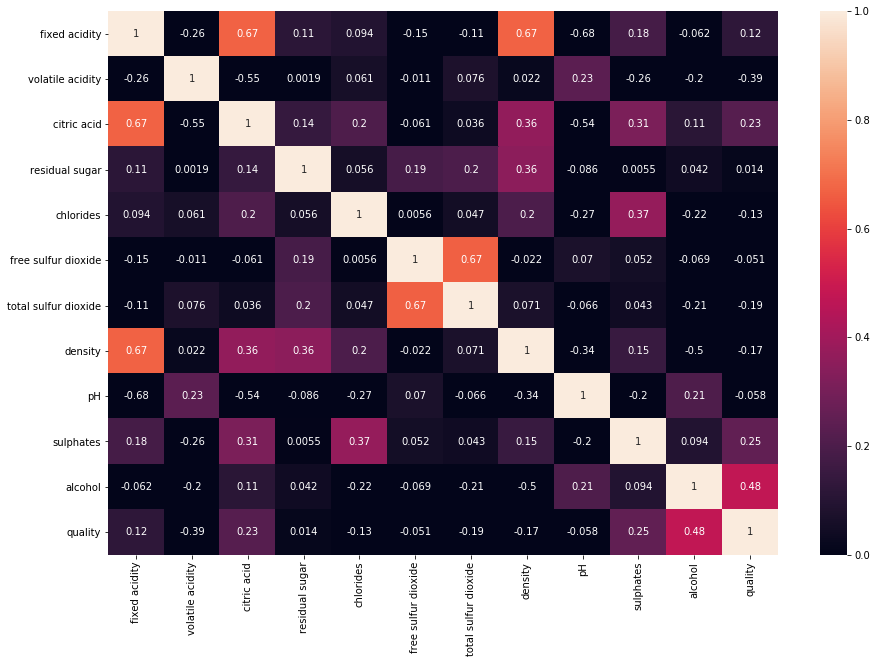

In [91]:
plt.figure(figsize=(15,10))
sns.heatmap(wine.corr(), annot = True, vmin = 0, vmax = 1)

From the first look at correlation matrix, we can observe that **Alcohol, fixed acidity, sulphates** and **citric acid** positively affects the quality of wine. This should serve as a good background when we investigate this further using feature importances. For now, lets split the data. 

### Train-valid-test split

In [75]:
from sklearn.model_selection import train_test_split

y = wine['quality']
X = wine.drop('quality', axis=1)

# 70% training and 30% validation + test
X_trainw, X_val_testw, y_trainw, y_val_testw = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_valw, X_testw, y_valw, y_testw = train_test_split(X_val_testw, y_val_testw, test_size=0.50)

print("Training Set:", X_trainw.shape)
print("Validation Set:", X_valw.shape)
print("Test Set:", X_testw.shape)

Training Set: (1119, 11)
Validation Set: (240, 11)
Test Set: (240, 11)


### Fitting model

We will be importing RandomForestRegressor straight from Scikit Learn and fitting the default model to our data...

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rfc = RandomForestRegressor()
rfc.fit(X_trainw, y_trainw)
rfc_pred_val = rfc.predict(X_valw)
errors = abs(rfc_pred_val - y_valw)
mape = 100 * np.mean(errors / y)
accuracy = 100 - mape

print("MAPE:", np.round(mape,2))
print("Accuracy:", np.round(accuracy,2))

MAPE: 7.83
Accuracy: 92.17


C:\Users\gaure\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Looks like our default model is in a good shape! We'll still go ahead tune it further to check if it can improve... 

### Hyperparameter tuning using RandomSearchCV

The most important settings in Random Forest are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features). We could go read the research papers on the random forest and try to theorize the best hyperparameters, but a more efficient use of our time is just to try out a wide range of values and see what works! 

We will try adjusting the following set of hyperparameters:
- **n_estimators** = number of trees in the foreset
- **max_features** = max number of features considered for splitting a node
- **max_depth** = max number of levels in each decision tree
- **min_samples_split** = min number of data points placed in a node before the node is split
- **min_samples_leaf** = min number of data points allowed in a leaf node
- **bootstrap** = method for sampling data points (with or without replacement)


To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:


In [78]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10,20,30,40,50,60,70,80,90,100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

### Why RandomSearchCV?

In Grid Search, we try every combination of a preset list of values of the hyper-parameters and evaluate the model for each combination. Each set of parameters is taken into consideration and the accuracy is noted. Once all the combinations are evaluated, the model with the set of parameters which give the top accuracy is considered to be the best.

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. To optimise with random search, the function is evaluated at some number of random configurations in the parameter space. The chances of finding the optimal parameter are comparatively higher in random search because of the random search pattern where the model might end up being trained on the optimised parameters without any aliasing. Random search works best for lower dimensional data since the time taken to find the right set is less with less number of iterations.

Simply put Grid Search will try out $$10 * 2 * 10 * 3 * 3 * 2 = 3600$$ combinations before deciding the best estimator where as Random Search will try out (mxn) combinations using the parameters grid passed as a distribution where **m=number of iterations** and **n=folds**.

In our case, we'll do 10 iterations for 5 folds each i.e $$10 * 5 = 50$$

In [79]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_trainw, y_trainw) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [80]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

### Model Evaluation 

To determine if random search yielded a better model, we compare the base model with the best random search model. We'll be creating a function that basically executes the same steps i.e calculating mean absolute percentage error and accuracy. 

In [81]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    errors = abs(predictions - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    print('Model Performance:')
    print('---------------------------')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

**Base Model**

In [82]:
base_model = RandomForestRegressor()
base_model.fit(X_trainw, y_trainw)
base_accuracy = evaluate(base_model, X_valw, y_valw)

Model Performance:
---------------------------
Average Error: 0.4467 degrees.
Accuracy = 91.99%.


C:\Users\gaure\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Best Model obtained from RandomSearchCV**

In [83]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valw, y_valw)

Model Performance:
---------------------------
Average Error: 0.4325 degrees.
Accuracy = 92.19%.


In [84]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.22%.


### Fitting model on Test Data

Random search model yeilds an improved accuracy by 0.2% so we will fit that model on our test data and see how it fares.

In [85]:
best_random.fit(X_trainw, y_trainw)
best_pred = best_random.predict(X_testw)
errors = abs(best_pred - y_testw)
mape = 100 * np.mean(errors / y)
accuracy = 100 - mape

print("MAPE:", mape)
print("Accuracy:", accuracy)

MAPE: 7.803385937425077
Accuracy: 92.19661406257492


### Feature Selection

In decision trees, every node is a condition of how to split values in a single feature, so that similar values of the dependent variable end up in the same set after the split. 

The condition is based on impurity, which in case of classification problems is _**Gini Impurity/Information Gain (Entropy)**_
while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity. 

**feature_importances_** in Scikit-Learn is based on that logic, but in the case of Random Forest, we are talking about averaging the decrease in impurity over trees.

Lets check our top 5 features on test set.

[0.05674717 0.14069909 0.06867106 0.05144131 0.0732104  0.04905473
 0.07934318 0.08895178 0.05524995 0.13733133 0.19929999]


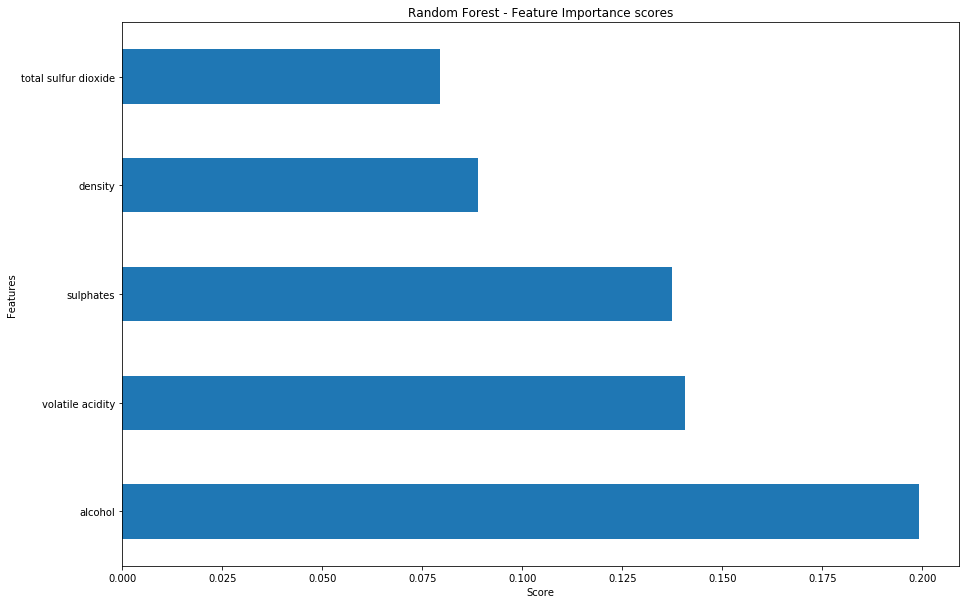

In [86]:
print(best_random.feature_importances_) 
plt.figure(figsize=(15,10))
feat_importances = pd.Series(best_random.feature_importances_, index=X_trainw.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Random Forest - Feature Importance scores")
plt.xlabel('Score')
plt.ylabel('Features')
plt.show()

Above, we see our top 5 features contributing to our outcome. What is surprising to see is, out of the features that were highlighed through the correlation matrix (alcohol, sulphates, citric acid, fixed acidity), only **Alchol** & **sulphates** made it to the top 5However, the impurity-based feature importance ranks the numerical features to be the most important features.

This problem stems from two limitations of impurity-based feature importances:

- impurity-based importances are biased towards high cardinality features

- impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set.

To mitigate this con, we can use Permutation Importance.

### Permutation Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome. 

In simple words, a feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

We'll compute permuted importances on our test set to see if we observe any difference in the order/rank of features. 

<Figure size 1080x720 with 0 Axes>

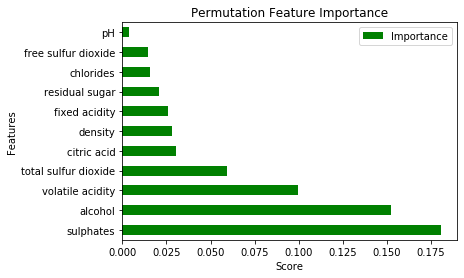

In [87]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

perm_imp_rfpimp = permutation_importances(best_random, X_testw, y_testw, r2)

plt.figure(figsize=(15,10))

perm_imp_rfpimp.plot(kind='barh', color='green')
plt.title("Permutation Feature Importance")
plt.xlabel('Score')
plt.ylabel('Features')
plt.show()

The plot confirms what we have seen with impurity based feature_importances. Our top 5 features stay the same. 